# density-随机森林拟合

要点梳理：
- 剔除云层遮挡和数据缺失的情况

拖山的经度和纬度是(120.14,31.406)，兰山嘴的经度和纬度是(119.89,31.212)。我需要分析这2个点位逐日的叶绿素a浓度，请你修改下面的代码。如果受到云层影响导致数据缺失，请你用NAN代替。

创新点在于，将云层覆盖的区域设置为999999，这样在后续处理中可以很容易地识别出这些区域。

https://engine-aiearth.aliyun.com/docs/page/api?d=07f36f#heading-22

https://engine-aiearth.aliyun.com/?spm=a2cvf.28031243.0.0.5dc743d42pbV5o#/utility/auth-token

In [1]:
import aie

aie.Authenticate(token='8f04bf5ebc3b343fcfc4373fd0dd4a33')
aie.Initialize()

计算资源初始化中，请等待...
计算资源初始化完成.


In [2]:
import geopandas as gpd

In [3]:
# 读取shp文件
shapefile_path = '/root/Download/Modis-algae-aliyun/local-data/taihu.shp'
gdf = gpd.read_file(shapefile_path)

# 假设shp文件中只有一个几何对象，取第一个
geometry = gdf.geometry.iloc[0]
print(geometry)
# 输出((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, ...

# 将geopandas的geometry对象转换为ee.Geometry
coords = list(geometry.exterior.coords)
flattened_coords = [coord for point in coords for coord in point]
taihu = aie.Geometry.Polygon(flattened_coords)
# 构造Polygon。输入参数支持GeoJSON 'Polygon'类型格式的坐标点集，
# 同时也支持包含偶数个数字的一维List，例如aie.Geometry.Polygon([aLng, aLat, bLng, bLat, ...])。
# 需注意，输入的坐标点将以EPSG:4326坐标系进行解析。

# 打印ee.Geometry对象以验证
print(taihu)

POLYGON ((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, 120.00611934273043 31.40820067954559, 120.0213482061359 31.420557311454473, 120.02780893606551 31.42562749019076, 120.03023170978913 31.42966374717613, 120.0274051404449 31.43596389857637, 120.02025218945138 31.447873965243872, 120.00888822698595 31.45166321445573, 120.01067646473432 31.455403102339847, 120.01448368058568 31.46224277412878, 120.01806015608244 31.467556706624215, 120.02342486932757 31.473017934057427, 120.02827041677476 31.47729813281918, 120.02902032292732 31.479561147303205, 120.03525031250228 31.481725718642263, 120.03871141782174 31.48452974796941, 120.04223020822982 31.48275879185581, 120.04678733023371 31.479659537995836, 120.05734370145801 31.476461787529658, 120.06017027080222 31.47651098451827, 120.06380443138762 31.471541958062947, 120.06276609979179 31.468442332717288, 120.06345832085567 31.46578542930369, 120.06703479635243 31.4656870240255, 120.07078432711515 31.46052060

# 计算完整的7月份

你这个逻辑还是有问题，请你用伪代码的方式，提供一个代码的逻辑框架，please think by chain-of-thought：


我需要你同步输出modis反演的藻密度和lanshanzui.csv'中的藻密度，使得二者之间的差距尽可能小。由于lanshanzui.csv'中的藻密度一天会产生6个值，因此lanshanzui.csv'中的藻密度将采用置信区间的形式，modis反演的藻密度将与“lanshanzui.csv'中的藻密度将采用置信区间”进行比较

请你分析并修改这段代码，我的顾虑是："""这段代码好像是通过2022年7月逐日的计算值逐步优化参数，应该根据遥感影像的sample的完整的2022年7月的结果一起计算？输出一个最终的优化参数？"""

需要你注意如下2种情况将不作为参数优化的计算依据：
- MODIS遥感影像中藻密度为9999.0，也就是云层遮挡的情况
- df['density']中数据缺失的情况。


## demo-1.0版本-计算失败

In [10]:
pip install scikit-learn -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [5]:
import datetime
import csv
import aie
import pandas as pd
import numpy as np
import chardet
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 步骤1: 数据准备
csv_file = '/root/Download/Modis-algae-aliyun/aie-taihu/00-lanshanzui.csv'

# 检测文件编码
with open(csv_file, 'rb') as f:
    result = chardet.detect(f.read())

# 使用探测到的编码读取文件
df = pd.read_csv(csv_file, encoding=result['encoding'])

# 将日期列转换为日期时间格式
df['date'] = pd.to_datetime(df['date'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 移除密度为NaN的数据
df = df.dropna(subset=['density'])

# 按日期分组并计算每日的统计数据
daily_stats = df['density'].resample('D').agg(['mean', 'std', 'count'])

# 计算95%置信区间
confidence_interval = 1.96 * daily_stats['std'] / np.sqrt(daily_stats['count'])

# 计算置信区间的上下限
daily_stats['lower_ci'] = daily_stats['mean'] - confidence_interval
daily_stats['upper_ci'] = daily_stats['mean'] + confidence_interval

# 步骤2: 收集所有有效数据
valid_features = {
    'ndci': [],
    'ndvi': [],
    'evi': [],
    'ndwi': [],
    'b1': [],
    'b2': [],
    'b5': []
}
valid_density_mean = []
valid_density_lower = []
valid_density_upper = []
start_date = datetime.date(2022, 7, 1)
end_date = datetime.date(2022, 8, 31)
delta = datetime.timedelta(days=1)
roi = aie.Geometry.BBox(119.89, 31.212, 119.90, 31.222)

def mask_clouds(image):
    qa = image.select('state_1km')
    cloud_bit_mask = 1 << 10
    mask = qa.bitwiseAnd(aie.Image.constant(cloud_bit_mask))
    return mask

In [11]:


while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
             .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
    
    cloud_mask = mask_clouds(img)
    ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
    ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
    ).rename(['evi'])
    ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
    
    ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(9999))
    ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(9999))
    evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(9999))
    ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(9999))
    b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(9999))
    b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(9999))
    b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(9999))
    
    current_date = pd.to_datetime(start_date)
    if current_date in daily_stats.index:
        mean_density = daily_stats.loc[current_date, 'mean']
        lower_ci = daily_stats.loc[current_date, 'lower_ci']
        upper_ci = daily_stats.loc[current_date, 'upper_ci']
        
        ndci_values = ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo()
        ndvi_values = ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo()
        evi_values = evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo()
        ndwi_values = ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo()
        b1_values = b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo()
        b2_values = b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo()
        b5_values = b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
        
        valid_indices = [i for i in range(len(ndci_values)) if ndci_values[i] != 9999.0]
        
        if valid_indices:
            valid_features['ndci'].extend([ndci_values[i] for i in valid_indices])
            valid_features['ndvi'].extend([ndvi_values[i] for i in valid_indices])
            valid_features['evi'].extend([evi_values[i] for i in valid_indices])
            valid_features['ndwi'].extend([ndwi_values[i] for i in valid_indices])
            valid_features['b1'].extend([b1_values[i] for i in valid_indices])
            valid_features['b2'].extend([b2_values[i] for i in valid_indices])
            valid_features['b5'].extend([b5_values[i] for i in valid_indices])
            valid_density_mean.extend([mean_density] * len(valid_indices))
            valid_density_lower.extend([lower_ci] * len(valid_indices))
            valid_density_upper.extend([upper_ci] * len(valid_indices))
    
    start_date += delta

# 打印收集到的数据统计信息
print(f"有效样本数量: {len(valid_features['ndci'])}")
for key in valid_features.keys():
    print(f"{key}范围: {min(valid_features[key])} 到 {max(valid_features[key])}")
print(f"密度均值范围: {min(valid_density_mean)} 到 {max(valid_density_mean)}")
print(f"密度下限范围: {min(valid_density_lower)} 到 {max(valid_density_lower)}")
print(f"密度上限范围: {min(valid_density_upper)} 到 {max(valid_density_upper)}")

# 步骤3: 准备训练数据
X = pd.DataFrame(valid_features)
y_mean = np.array(valid_density_mean)
y_lower = np.array(valid_density_lower)
y_upper = np.array(valid_density_upper)

# 检查并移除包含NaN的行
mask = ~np.isnan(y_mean) & ~np.isnan(y_lower) & ~np.isnan(y_upper)
X = X[mask]
y_mean = y_mean[mask]
y_lower = y_lower[mask]
y_upper = y_upper[mask]

# 步骤4: 训练随机森林模型
X_train, X_test, y_mean_train, y_mean_test, y_lower_train, y_lower_test, y_upper_train, y_upper_test = train_test_split(
    X, y_mean, y_lower, y_upper, test_size=0.2, random_state=42)

rf_model_mean = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_mean.fit(X_train, y_mean_train)

rf_model_lower = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_lower.fit(X_train, y_lower_train)

rf_model_upper = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_upper.fit(X_train, y_upper_train)

# 步骤5: 评估模型
y_mean_pred = rf_model_mean.predict(X_test)
y_lower_pred = rf_model_lower.predict(X_test)
y_upper_pred = rf_model_upper.predict(X_test)

print("均值模型 R-squared:", r2_score(y_mean_test, y_mean_pred))
print("下限模型 R-squared:", r2_score(y_lower_test, y_lower_pred))
print("上限模型 R-squared:", r2_score(y_upper_test, y_upper_pred))

print("均值模型 MSE:", mean_squared_error(y_mean_test, y_mean_pred))
print("下限模型 MSE:", mean_squared_error(y_lower_test, y_lower_pred))
print("上限模型 MSE:", mean_squared_error(y_upper_test, y_upper_pred))

# 步骤6: 特征重要性
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': rf_model_mean.feature_importances_,
    'importance_lower': rf_model_lower.feature_importances_,
    'importance_upper': rf_model_upper.feature_importances_
})
print("特征重要性:")
print(feature_importance.sort_values('importance_mean', ascending=False))

# 输出模型结果
print("随机森林模型训练完成")
print("可以使用这些模型来预测新的数据")


有效样本数量: 46
ndci范围: -0.052804604172706604 到 0.20655737817287445
ndvi范围: -3.65116286277771 到 0.17024463415145874
evi范围: -117.2727279663086 到 1.8870192766189575
ndwi范围: -0.10136986523866653 到 0.6066433787345886
b1范围: -100.0 到 8419.0
b2范围: 57.0 到 8375.0
b5范围: 50.0 到 7666.0
密度均值范围: 13316666.666666666 到 78433333.33333333
密度下限范围: -593918.0570126772 到 63902812.23538995
密度上限范围: 14983947.220276179 到 119769899.46780816
均值模型 R-squared: -4.389636074158354
下限模型 R-squared: -3.8645448001821077
上限模型 R-squared: -4.784592876436932
均值模型 MSE: 236801403067525.72
下限模型 MSE: 103921428548490.9
上限模型 MSE: 499668708960088.2
特征重要性:
  feature  importance_mean  importance_lower  importance_upper
0    ndci         0.241870          0.210821          0.251132
6      b5         0.190797          0.241368          0.181679
3    ndwi         0.147294          0.107561          0.144131
5      b2         0.118193          0.140063          0.110548
4      b1         0.116729          0.122455          0.080505
2     evi   

In [13]:
# 保存随机森林模型
import joblib

# 创建一个目录来保存模型（如果不存在）
import os
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# 保存均值模型
joblib.dump(rf_model_mean, 'saved_models/rf_model_mean.joblib')

# 保存下限模型
joblib.dump(rf_model_lower, 'saved_models/rf_model_lower.joblib')

# 保存上限模型
joblib.dump(rf_model_upper, 'saved_models/rf_model_upper.joblib')

print("随机森林模型已保存到 'saved_models' 目录")


随机森林模型已保存到 'saved_models' 目录


已加载保存的随机森林模型
日期: 2022_07_01
藻密度估算结果 (均值): 21240000.00000002
藻密度估算结果 (下限): 16702439.173739236
藻密度估算结果 (上限): 23919349.37329859
---
日期: 2022_07_02
藻密度估算结果 (均值): 数据不可用
藻密度估算结果 (下限): 数据不可用
藻密度估算结果 (上限): 数据不可用
---
日期: 2022_07_03
藻密度估算结果 (均值): 16757000.000000015
藻密度估算结果 (下限): 14764567.383924162
藻密度估算结果 (上限): 18426912.521099817
---
日期: 2022_07_04
藻密度估算结果 (均值): 23972753.133333344
藻密度估算结果 (下限): 17821664.619218566
藻密度估算结果 (上限): 31637456.706846718
---
日期: 2022_07_05
藻密度估算结果 (均值): 19555514.850000028
藻密度估算结果 (下限): 14968485.60086792
藻密度估算结果 (上限): 23460835.05012919
---
日期: 2022_07_06
藻密度估算结果 (均值): 数据不可用
藻密度估算结果 (下限): 数据不可用
藻密度估算结果 (上限): 数据不可用
---
日期: 2022_07_07
藻密度估算结果 (均值): 数据不可用
藻密度估算结果 (下限): 数据不可用
藻密度估算结果 (上限): 数据不可用
---
日期: 2022_07_08
藻密度估算结果 (均值): 50093333.33333332
藻密度估算结果 (下限): 21861902.099215444
藻密度估算结果 (上限): 76959226.54269741
---
日期: 2022_07_09
藻密度估算结果 (均值): 26706166.666666664
藻密度估算结果 (下限): 19561144.476055697
藻密度估算结果 (上限): 32849951.225645937
---
日期: 2022_07_10
藻密度估算结果 (均值): 数据不可用
藻密度估算结果 (下限):

/tmp/ipykernel_744/1388118584.py:100: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1388118584.py:100: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1388118584.py:100: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1388118584.py:100: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1388118584.py:100: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1388118584.py:100: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1388118584.py:100: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  plt.tight_l

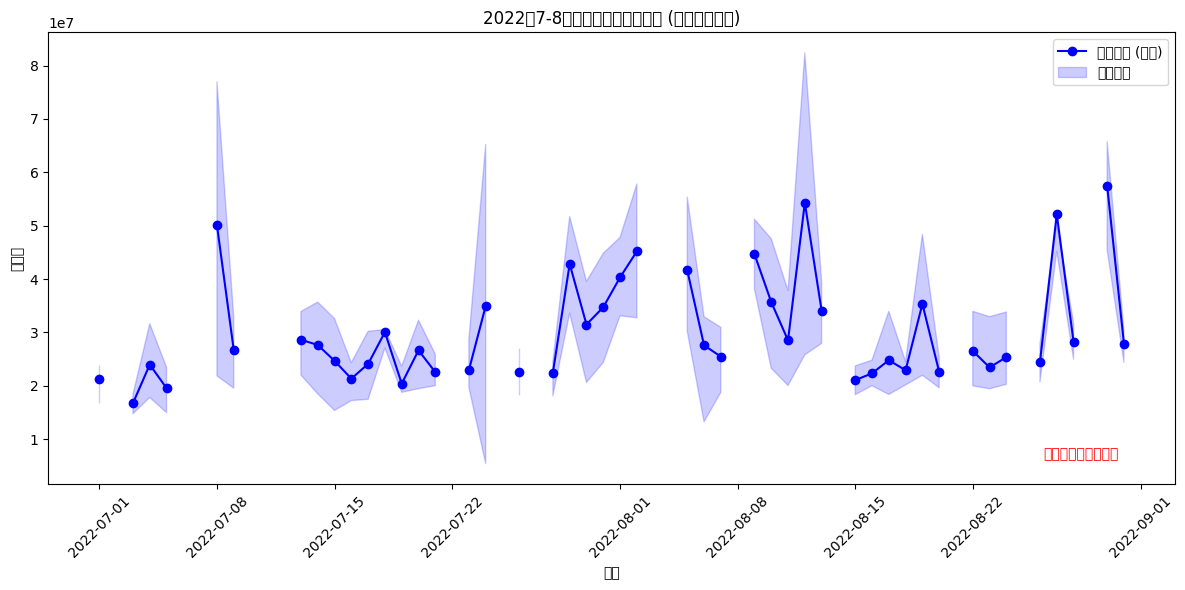

NameError: name 'X' is not defined

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
import joblib

# 加载保存的随机森林模型
rf_model_mean = joblib.load('saved_models/rf_model_mean.joblib')
rf_model_lower = joblib.load('saved_models/rf_model_lower.joblib')
rf_model_upper = joblib.load('saved_models/rf_model_upper.joblib')

print("已加载保存的随机森林模型")

# 步骤5: 应用随机森林模型并绘制结果
start_date = datetime.date(2022, 7, 1)
end_date = datetime.date(2022, 8, 31)
dates = []
estimated_densities_mean = []
estimated_densities_lower = []
estimated_densities_upper = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
             .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
    
    cloud_mask = mask_clouds(img)
    ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
    ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
    ).rename(['evi'])
    ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
    
    ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(9999))
    ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(9999))
    evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(9999))
    ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(9999))
    b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(9999))
    b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(9999))
    b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(9999))
    
    # 获取所有特征的值
    ndci_values = ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo()
    ndvi_values = ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo()
    evi_values = evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo()
    ndwi_values = ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo()
    b1_values = b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo()
    b2_values = b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo()
    b5_values = b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
    
    # 过滤掉云覆盖的像素
    valid_indices = [i for i in range(len(ndci_values)) if ndci_values[i] != 9999.0]
    
    if valid_indices:
        X_predict = pd.DataFrame({
            'ndci': [ndci_values[i] for i in valid_indices],
            'ndvi': [ndvi_values[i] for i in valid_indices],
            'evi': [evi_values[i] for i in valid_indices],
            'ndwi': [ndwi_values[i] for i in valid_indices],
            'b1': [b1_values[i] for i in valid_indices],
            'b2': [b2_values[i] for i in valid_indices],
            'b5': [b5_values[i] for i in valid_indices]
        })
        
        # 使用加载的随机森林模型进行预测
        estimated_density_mean = rf_model_mean.predict(X_predict)
        estimated_density_lower = rf_model_lower.predict(X_predict)
        estimated_density_upper = rf_model_upper.predict(X_predict)
    else:
        estimated_density_mean = []
        estimated_density_lower = []
        estimated_density_upper = []
    
    # 存储结果
    dates.append(start_date)
    estimated_densities_mean.append(np.mean(estimated_density_mean) if len(estimated_density_mean) > 0 else np.nan)
    estimated_densities_lower.append(np.mean(estimated_density_lower) if len(estimated_density_lower) > 0 else np.nan)
    estimated_densities_upper.append(np.mean(estimated_density_upper) if len(estimated_density_upper) > 0 else np.nan)
    
    print(f"日期: {date_str}")
    print(f"藻密度估算结果 (均值): {np.mean(estimated_density_mean) if len(estimated_density_mean) > 0 else '数据不可用'}")
    print(f"藻密度估算结果 (下限): {np.mean(estimated_density_lower) if len(estimated_density_lower) > 0 else '数据不可用'}")
    print(f"藻密度估算结果 (上限): {np.mean(estimated_density_upper) if len(estimated_density_upper) > 0 else '数据不可用'}")
    print("---")
    
    start_date += timedelta(days=1)

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(dates, estimated_densities_mean, label='估算结果 (均值)', color='blue', marker='o')
plt.fill_between(dates, estimated_densities_lower, estimated_densities_upper, alpha=0.2, color='blue', label='估算范围')

plt.xlabel('日期')
plt.ylabel('藻密度')
plt.title('2022年7-8月太湖藻密度估算结果 (随机森林模型)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# 添加云覆盖说明
plt.text(0.95, 0.05, '缺失数据表示云覆盖', transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='bottom', color='red')

plt.show()


特征重要性:
  feature  importance_mean  importance_lower  importance_upper
0    ndci         0.241870          0.210821          0.251132
6      b5         0.190797          0.241368          0.181679
3    ndwi         0.147294          0.107561          0.144131
5      b2         0.118193          0.140063          0.110548
4      b1         0.116729          0.122455          0.080505
2     evi         0.092630          0.083363          0.092845
1    ndvi         0.092488          0.094369          0.139160


/tmp/ipykernel_744/1651507804.py:18: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1651507804.py:18: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1651507804.py:18: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1651507804.py:18: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1651507804.py:18: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1651507804.py:18: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_744/1651507804.py:18: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  plt.tight_layout()

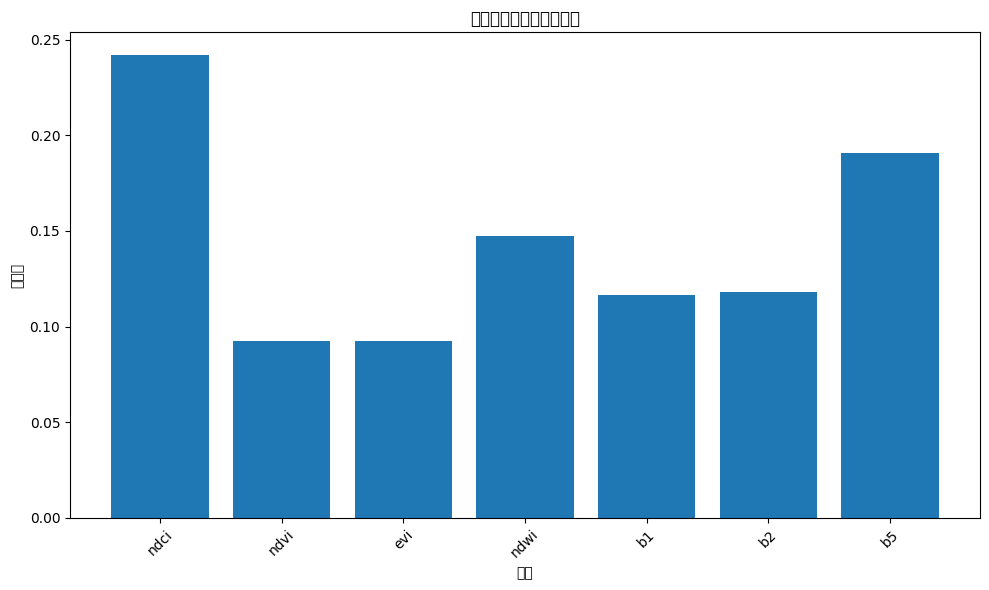

随机森林模型应用完成
藻密度估算已完成


In [7]:

# 步骤6: 特征重要性
feature_importance = pd.DataFrame({
    'feature': ['ndci', 'ndvi', 'evi', 'ndwi', 'b1', 'b2', 'b5'],
    'importance_mean': rf_model_mean.feature_importances_,
    'importance_lower': rf_model_lower.feature_importances_,
    'importance_upper': rf_model_upper.feature_importances_
})
print("特征重要性:")
print(feature_importance.sort_values('importance_mean', ascending=False))

# 绘制特征重要性图表
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance_mean'])
plt.xlabel('特征')
plt.ylabel('重要性')
plt.title('随机森林模型特征重要性')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 输出模型结果
print("随机森林模型应用完成")
print("藻密度估算已完成")